In [42]:
#import necessary packages
import gym
import numpy as np
import random
from gym.envs.toy_text.frozen_lake import generate_random_map
from tqdm import trange
import matplotlib.pyplot as plt

# Create fronzen lake environment:
- 4x4 standard map without slippery
- 10x10 random map with 25% holes without slippery

In [43]:
#Part1: generate frozen lake 4x4 model for 
env = gym.make('FrozenLake-v0', is_slippery=False)
env.render()


SFFF
FHFH
FFFH
HFFG


In [87]:
#Part2: generate frozen lake random map 10x10 with 25% holes
random_map = generate_random_map(size=10, p=0.75)
env2 = gym.make('FrozenLake-v0', desc=random_map, is_slippery=False)
env2.reset()
env2.render()


SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG


In [44]:
#define a tie-braking argmax function, 
#as np.argmax only returns the first instance of the highest value

def argmax(q):
    """tie-breaking argmax
    Input: 
        q values (array)
    Return: 
        index of maximum q value (int)
    """
    max_value = float("-inf")
    ties = []
    for i in range(len(q)):
        if q[i] > max_value:
            max_value = q[i]
            ties = [i]
        elif q[i] == max_value:
            ties.append(i)
            
    return np.random.choice(ties)

# Implementation:

## Method 1: First-visit MC control without exploring starts

In [45]:
#generate random policy (equal probability)
def generate_random_policy(env):
    """generate initial policy with equal probability
    Input:
        env - environment
    Return: 
        policy (dict) - initial policy
    """
    policy = dict()
    states = env.observation_space.n
    actions = env.action_space.n
    for state in range(states):
        proba = dict()
        for action in range(actions):
            proba[action] = 1 / actions
        policy[state] = proba
    return policy

In [46]:
#initialize Q and returns
def initialize_parameters(env, policy):
    """initialize q_values
    Input:
        env - environment
        policy (dict) - initial policy
    Return:
        Q (dict) - action values
    """
    Q = dict() 
    returns = dict()
    for state in policy.keys():
        Q[state] = {a: 0 for a in range(env.action_space.n)}
    return Q, returns

In [47]:
def epsilon_greedy_MC(a_optimal, epsilon):
    """epsilon_greedy
    Input: 
        a_optimal (int) - optimal action
        epsilon (float) - exploration factor
    Return:
        action (int) - action chosen
    """
    proba = np.random.random()
    if proba < 1-epsilon:
        return a_optimal
    else:
        return np.random.randint(0, env.action_space.n)

In [48]:
def generate_episode_MC(env, policy, epsilon, display=False):
    """generate one episode 
    Input:
        env - environment
        policy (dict)" - initial randomly generated policy
        epsilon (float) - exploration factor
        display (boolean) - call env.render() for visualization
    Return:
        episode (list) - containing [state, action, reward, done] for prediction
        length of episode (int) 
    """
    env.reset()
    episode = []
    done = False
    
    while not done:  
        s = env.env.s
        a_optimal = argmax(list(policy[s].values()))  
        a_t = epsilon_greedy_MC(a_optimal, epsilon)
        s_t, r_t, done, _ = env.step(a_t)
        episode.append([s,a_t, r_t, done])
        if display == True:
            env.render()
    if episode[-1][-2] == 0:   #change the reward of falling in holes for 10x10 map
        episode[-1][-2] = -1
        
    return episode, len(episode)    

In [49]:
def first_visit_MC(random_env, ep=100, epsilon=0.15, gamma=0.95):
    """first visit MC without ES implementation
    Input: 
        env -environment
        ep (int)-number of episodes to run
        epsilon (float)-allow exploration
        gamma (float)- discount factor
    Return:
        policy (dict) - final policy after training
        reward_record (list) - list of reward received in every episode
    """
    #initialize 
    env = random_env
    t = trange(ep)
    actions = env.action_space.n
    policy = generate_random_policy(env)
    Q, returns = initialize_parameters(env, policy)
    reward_record = np.zeros(ep)

    for i in t:
        G = 0
        #run one episode
        episode, T = generate_episode_MC(env, policy, epsilon)
        reward_record[i] = episode[-1][-2]
        #Loop for each step of episode in reverse order
        for t in reversed(range(0, T)):
            s_t, a_t, r_t, _ = episode[t] #tuple(state at t, action at t, reward at t+1)
            G = gamma * G + r_t
            # only count the first visited (state, action) pair
            if not (s_t, a_t) in [episode[i][:1] for i in range(t)]:
                if returns.get((s_t,a_t)):
                    returns[(s_t,a_t)].append(G)
                else:
                    returns[(s_t,a_t)] = [G]
                Q[s_t][a_t] = np.average(returns[(s_t,a_t)]) 
                #policy improvement
                q_values = list(Q[s_t].values())
                a_optimal = argmax(q_values)
                for action in policy[s_t].items():
                    if action[0] == a_optimal:
                        policy[s_t][action[0]] = 1-epsilon+(epsilon/actions)
                    else:
                        policy[s_t][action[0]] = epsilon/actions
                            
    return policy, reward_record

## Method 2: SARSA with ϵ-greedy behavior policy

In [50]:
def epsilon_greedy(Q, epsilon, actions, state):
    """perform ϵ-greedy action selection
    Input:
    Q (array) - q values
    epsilon (float) - exploration factor
    actions (int) - total number of actions 
    state (int) - current state 
    Return:
    action (int) - action selected
    """
    proba = np.random.random()
    if proba < 1-epsilon:
        return argmax(Q[state, :])
    else:
        return np.random.randint(actions)

In [51]:
def sarsa(random_env, step_size, gamma, epsilon, ep):
    """sarsa implementation
    Input:
    step_size (float) - learning rate
    gamma (float) - discount rate
    epsilon (float) - exploration paramater
    ep (int) - number of episodes
    Return:
    Q (array) - q values of state-action pairs
    reward (list) - reward received after each episode
    """
    #initialize state action pairs Q, list of rewards received per episode
    env = random_env
    t = trange(ep)
    actions = env.action_space.n
    states = env.observation_space.n
    Q = np.zeros((states, actions))
    reward_record = np.zeros(ep)
    
    for i in t:
        env.reset()
        done = False
        state = env.env.s
        action = epsilon_greedy(Q, epsilon, actions, state)
        
        while not done:
            s_t, r_t, done, _ = env.step(action)
            a_t = epsilon_greedy(Q, epsilon, actions, s_t)
            if done:
                if r_t == 0:   #change the reward to -1 if it's a hole
                    r_t = -1
                #update Q, when episode end, no next state q_value to be updated
                Q[state, action] += step_size * (r_t - Q[state, action])
                reward_record[i] = r_t   
            else:
                Q[state, action] += step_size * (r_t + (gamma * Q[s_t, a_t]) - Q[state, action])
                
            state, action = s_t, a_t
            
    return Q, reward_record

In [52]:
#generate episode for visualization and verification pupose
#can be used for both SARSA and Qlearning
def generate_episode_sarsa(random_env, Q, display=True, epsilon=0):
    """generate one episode for visualization
    """
    env = random_env
    env.reset()
    episode = []
    done = False
    actions = env.action_space.n
    states = env.observation_space.n
    
    while not done:
        state = env.env.s    
        a_optimal = argmax(Q[state])
        a_t = epsilon_greedy(Q, epsilon, actions, state)
        s_t, r_t, done, _ = env.step(a_t)        
        episode.append((state, a_t, r_t, done))
        if display == True:
            env.render()
    return episode, len(episode) 

## Method 3: Q learning with an ϵ-greedy behavior policy

In [53]:
def qlearning(random_env, step_size, gamma, epsilon, ep):
    """
    Input:
    step_size(float): learning rate alpha
    gamma(float): discount rate
    epsilon(float): exploration paramater
    ep(int): number of episodes
    Return:
    Q (array) - q values of state-action pairs
    reward (list) - reward received after each episode
    """
    env = random_env
    t = trange(ep)
    actions = env.action_space.n
    states = env.observation_space.n
    Q = np.zeros((states, actions))
    reward_record = np.zeros(ep)
    
    for i in t:
        env.reset()
        done = False
        state = env.env.s
                
        while not done:
            action = epsilon_greedy(Q, epsilon, actions, state)
            s_t, r_t, done, _ = env.step(action)

            if done:
                if r_t == 0:  #change the reward of holes to -1 instead of 0
                    r_t = -1
                #update q value accordingly 
                Q[state, action] += step_size * (r_t - Q[state, action])
                reward_record[i] = r_t
            else:
                Q[state, action] += step_size * (r_t + (gamma * np.max(Q[s_t, :]) - Q[state, action]))
                
            state = s_t
            
    return Q, reward_record

# Results:
## Part 1: 4x4 map 

In [68]:
# set the parameters
step_size = 0.1
gamma = 0.95
epsilon = 0.15
episode = 500

In [69]:
reward_sums = {}

reward_sums["first visit MC"] = first_visit_MC(env, episode, epsilon, gamma)[1]
reward_sums["Sarsa"] = sarsa(env, step_size, gamma, epsilon, episode)[1]
reward_sums["Q-learning"] = qlearning(env, step_size, gamma, epsilon, episode)[1]

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1831.41it/s]


C:\Users\DINGMAN\Anaconda3\envs\6.86x\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DINGMAN\Anaconda3\envs\6.86x\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


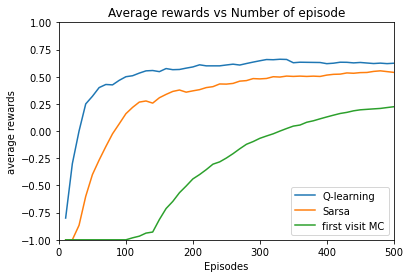

In [85]:
eps = np.arange(0,501,10)
avg_reward_all = {}
for ep in eps:
    for method in ["Q-learning", "Sarsa", "first visit MC"]:
        if avg_reward_all.get(method):
            avg_reward_all[method].append(np.mean(reward_sums[method][:ep]))
        else:
            avg_reward_all[method] = [np.mean(reward_sums[method][:ep])]

#plot graph average reward per episode vs episode
for method in ["Q-learning", "Sarsa", "first visit MC"]:
    plt.plot(eps, avg_reward_all[method], label=method)
plt.title('Average rewards vs Number of episode')
plt.xlabel("Episodes")
plt.ylabel("average rewards")
plt.xlim(0,500)
plt.ylim(-1,1)
plt.legend()
plt.show()

100%|████████████████████████████████████| 3000/3000 [00:01<00:00, 1713.16it/s]


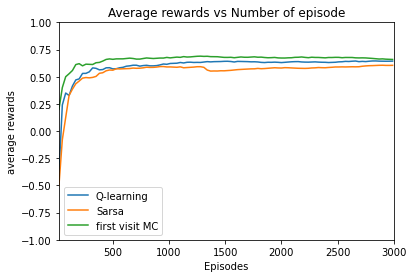

In [100]:
#test convergence, use 1000 episode for training
episode = 3000
reward_sums = {}
reward_sums["first visit MC"] = first_visit_MC(env, episode, epsilon, gamma)[1]
reward_sums["Sarsa"] = sarsa(env, step_size, gamma, epsilon, episode)[1]
reward_sums["Q-learning"] = qlearning(env, step_size, gamma, epsilon, episode)[1]
eps = np.arange(20,3001,30)
avg_reward_all = {}
for ep in eps:
    for method in ["Q-learning", "Sarsa", "first visit MC"]:
        if avg_reward_all.get(method):
            avg_reward_all[method].append(np.mean(reward_sums[method][:ep]))
        else:
            avg_reward_all[method] = [np.mean(reward_sums[method][:ep])]

#plot graph average reward per episode vs episode
for method in ["Q-learning", "Sarsa", "first visit MC"]:
    plt.plot(eps, avg_reward_all[method], label=method)
plt.title('Average rewards vs Number of episode')
plt.xlabel("Episodes")
plt.ylabel("average rewards")
plt.xlim(20,3000)
plt.ylim(-1,1)
plt.legend()
plt.show()

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 503.60it/s]
C:\Users\DINGMAN\Anaconda3\envs\6.86x\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\DINGMAN\Anaconda3\envs\6.86x\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


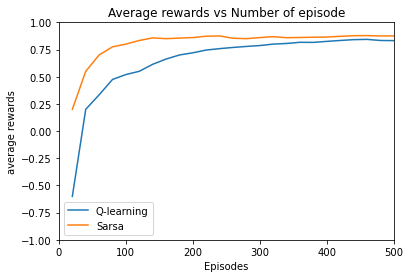

In [103]:
#use smaller epsilon to compare Q-learning and SARSA
epsilon = 0.05
episode = 500
reward_sums = {}
reward_sums["Sarsa"] = sarsa(env, step_size, gamma, epsilon, episode)[1]
reward_sums["Q-learning"] = qlearning(env, step_size, gamma, epsilon, episode)[1]
eps = np.arange(0,501,20)
avg_reward_all = {}
for ep in eps:
    for method in ["Q-learning", "Sarsa"]:
        if avg_reward_all.get(method):
            avg_reward_all[method].append(np.mean(reward_sums[method][:ep]))
        else:
            avg_reward_all[method] = [np.mean(reward_sums[method][:ep])]

#plot graph average reward per episode vs episode
for method in ["Q-learning", "Sarsa"]:
    plt.plot(eps, avg_reward_all[method], label=method)
plt.title('Average rewards vs Number of episode')
plt.xlabel("Episodes")
plt.ylabel("average rewards")
plt.xlim(0,500)
plt.ylim(-1,1)
plt.legend()
plt.show()

In [120]:
#generate one episode to visualize the optimal policy 
#obtained using SARSA
Q = sarsa(env, step_size, gamma, epsilon, 200)[0]
generate_episode_sarsa(env, Q, display=True)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 554.34it/s]

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


([(0, 2, 0.0, False),
  (1, 2, 0.0, False),
  (2, 1, 0.0, False),
  (6, 1, 0.0, False),
  (10, 1, 0.0, False),
  (14, 2, 1.0, True)],
 6)

In [124]:
#generate one episode to visualize the optimal policy 
#obtained using Q-learning
Q = qlearning(env, step_size, gamma, epsilon, 200)[0]
generate_episode_sarsa(env, Q, False)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 338.03it/s]


([(0, 2, 0.0, False),
  (1, 2, 0.0, False),
  (2, 1, 0.0, False),
  (6, 1, 0.0, False),
  (10, 1, 0.0, False),
  (14, 2, 1.0, True)],
 6)

In [127]:
#generate one episode to visualize the optimal policy 
#obtained using first-visit MC
policy =  first_visit_MC(env, 500, epsilon, gamma)[0]
generate_episode_MC(env, policy, 0, display=False)

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 177.35it/s]


([[0, 1, 0.0, False],
  [4, 1, 0.0, False],
  [8, 2, 0.0, False],
  [9, 2, 0.0, False],
  [10, 1, 0.0, False],
  [14, 2, 1.0, True]],
 6)

## Part 2: 10x10 random map

In [104]:
# set the parameters for testing
step_size = 0.1
gamma = 0.95
epsilon = 0.15
episode = 2000

In [105]:
reward_sums = {}

reward_sums["first visit MC"] = first_visit_MC(env2, episode, epsilon, gamma)[1]
reward_sums["Sarsa"] = sarsa(env2, step_size, gamma, epsilon, episode)[1]
reward_sums["Q-learning"] = qlearning(env2, step_size, gamma, epsilon, episode)[1]

100%|█████████████████████████████████████| 2000/2000 [00:04<00:00, 402.97it/s]


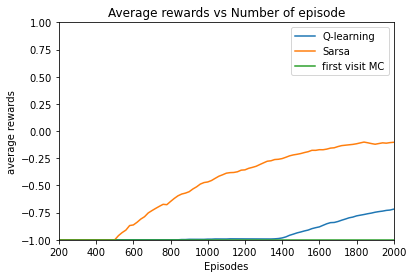

In [107]:
eps = np.arange(200,2001,20)
avg_reward_all = {}
for ep in eps:
    for method in ["Q-learning", "Sarsa", "first visit MC"]:
        if avg_reward_all.get(method):
            avg_reward_all[method].append(np.mean(reward_sums[method][:ep]))
        else:
            avg_reward_all[method] = [np.mean(reward_sums[method][:ep])]

#plot graph average reward per episode vs episode
for method in ["Q-learning", "Sarsa", "first visit MC"]:
    plt.plot(eps, avg_reward_all[method], label=method)
plt.title('Average rewards vs Number of episode')
plt.xlabel("Episodes")
plt.ylabel("average rewards")
plt.xlim(200,2000)
plt.ylim(-1,1)
plt.legend()
plt.show()

100%|███████████████████████████████████| 20000/20000 [00:48<00:00, 416.49it/s]


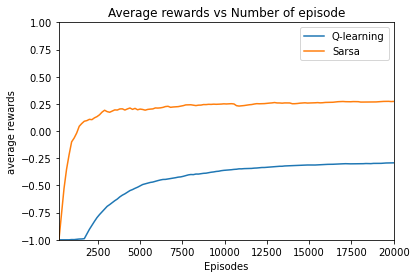

In [118]:
#test convergence of Q-learning and SARSA
epsilon = 0.15
episode = 20000
reward_sums = {}
reward_sums["Sarsa"] = sarsa(env2, step_size, gamma, epsilon, episode)[1]
reward_sums["Q-learning"] = qlearning(env2, step_size, gamma, epsilon, episode)[1]
eps = np.arange(200,20001,150)
avg_reward_all = {}
for ep in eps:
    for method in ["Q-learning", "Sarsa"]:
        if avg_reward_all.get(method):
            avg_reward_all[method].append(np.mean(reward_sums[method][:ep]))
        else:
            avg_reward_all[method] = [np.mean(reward_sums[method][:ep])]

#plot graph average reward per episode vs episode
for method in ["Q-learning", "Sarsa"]:
    plt.plot(eps, avg_reward_all[method], label=method)
plt.title('Average rewards vs Number of episode')
plt.xlabel("Episodes")
plt.ylabel("average rewards")
plt.xlim(200, 20000)
plt.ylim(-1,1)
plt.legend()
plt.show()

In [119]:
#generate one episode to visualize the optimal policy 
#obtained by SARSA
Q = sarsa(env2, step_size, gamma, epsilon, 2000)[0]
generate_episode_sarsa(env2, Q, display=True)

100%|█████████████████████████████████████| 2000/2000 [00:09<00:00, 210.11it/s]

  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFF

([(0, 1, 0.0, False),
  (10, 1, 0.0, False),
  (20, 1, 0.0, False),
  (30, 1, 0.0, False),
  (40, 1, 0.0, False),
  (50, 1, 0.0, False),
  (60, 2, 0.0, False),
  (61, 1, 0.0, False),
  (71, 2, 0.0, False),
  (72, 2, 0.0, False),
  (73, 1, 0.0, False),
  (83, 2, 0.0, False),
  (84, 2, 0.0, False),
  (85, 2, 0.0, False),
  (86, 2, 0.0, False),
  (87, 2, 0.0, False),
  (88, 2, 0.0, False),
  (89, 1, 1.0, True)],
 18)

In [123]:
#generate one episode to visualize the optimal policy 
#obtained by Qlearning
Q = qlearning(env2, step_size, gamma, epsilon, 2000)[0]
generate_episode_sarsa(env2, Q, display=True)

100%|█████████████████████████████████████| 2000/2000 [00:14<00:00, 139.54it/s]

  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Right)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
FFFFHFHFHF
FHFHFFFFFH
FFHFHFFHFF
FFHFHFFHFF
FFFFFFFFFH
HFFFFFFFFF
HHFFFFFFHG
  (Down)
SFFFHFFFFF
FHHFFHFFFH
FFFHFFFFHH
F

([(0, 2, 0.0, False),
  (1, 2, 0.0, False),
  (2, 2, 0.0, False),
  (3, 1, 0.0, False),
  (13, 2, 0.0, False),
  (14, 1, 0.0, False),
  (24, 2, 0.0, False),
  (25, 1, 0.0, False),
  (35, 1, 0.0, False),
  (45, 1, 0.0, False),
  (55, 1, 0.0, False),
  (65, 1, 0.0, False),
  (75, 2, 0.0, False),
  (76, 1, 0.0, False),
  (86, 2, 0.0, False),
  (87, 2, 0.0, False),
  (88, 2, 0.0, False),
  (89, 1, 1.0, True)],
 18)